# ClimateLearn Quickstart

This notebook shows how to develop a weather forecasting model with deep learning in ClimateLearn from end-to-end. First, we install the library from the GitHub repository.

Mount the Google Drive file system, then import ClimateLearn and related libraries.

In [1]:
from src.climate_learn import LitModule
from src.climate_learn import download_weatherbench
from src.climate_learn import convert_nc2npz
from src.climate_learn import IterDataModule
from src.climate_learn.utils import visualize_at_index, visualize_mean_bias
from src.climate_learn import load_downscaling_module
from IPython.display import HTML
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar,
)
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torch

Download temperature and geopotential data from the ERA5 dataset. For more info about ERA5, please see these links:
- https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.3803
- https://en.wikipedia.org/wiki/ECMWF_re-analysis

Since temperature and geopotential are available at many different pressure levels ([what are pressure levels?](https://en.wikipedia.org/wiki/Atmospheric_pressure)), the complete ERA5 data for these two variables is very large and will take a long time to download. Moreover, it will require more storage space than is allotted to a free Google Drive account. For the sake of this quickstart, we will use pre-processed data provided by [WeatherBench](https://mediatum.ub.tum.de/1524895) for temperature at 850 hPa and geopotential at 500 hPa, which are called `temperature_850` and `geopotential_500`. Even at just one pressure level for each variable, the following code cells will still take a couple minutes to run, so we do not recommend you do not use hardware acceleration since [Google Colab has usage limits for GPU](https://stackoverflow.com/a/66142367).

In [ ]:
download_weatherbench(
    dst="/app/data/ClimateLearn/raw/ERA5/2.8125/2m_temperature_test",
    dataset="era5",
    variable="2m_temperature",
    resolution=2.8125,
)

In [3]:
download_weatherbench(
    dst="/app/data/ClimateLearn/raw/ERA5/5.625/2m_temperature",
    dataset="era5",
    variable="2m_temperature",
    resolution=5.625,
)

The following function call processes the WeatherBench ERA5 data into a form that is easily ingestable for PyTorch models and defines the training-validation-testing splits. In addition, we shard the data to create sets of smaller files rather than one large file for each split.

In [4]:
convert_nc2npz(
    root_dir="/app/data/ClimateLearn/raw/ERA5/2.8125",
    save_dir="/app/data/ClimateLearn/processed/ERA5/2.8125_24sh",
    variables=["2m_temperature"],
    start_train_year=1979,
    start_val_year=2015,
    start_test_year=2017,
    end_year=2018,
    num_shards=24,
)

The downloaded and processed data is loaded into a PyTorch Lightning data module. In the following code cell, we use the following settings:
- `subsample = 6`. The dataset is subsampled at 6 hour intervals; this is done so that training is faster, but one could also use no subsampling (_i.e._, `subsample = 1`, which is the default).
- `pred_range = 24`. The model's objective is to predict `2m_temperature` 24 hours in the future.
- `history = 3`. When making a prediction, the model is given data at time `t`, `t-subsample`, and `t-subsample*2`.
- `task = "direct-forecasting"`. Given the inputs, the model directly predicts the outputs at `pred_range`. Other methods of forecasting are iterative forecasting and continuous forecasting. We refer to section 3 of [this paper by Rasp and Theurey](https://arxiv.org/pdf/2008.08626.pdf) for a description of these forecasting types.

Note further that `in_vars` and `out_vars` are the same, meaning the model consumes historical temperature and geopotential as input and produces predicted temperature and geopotential as output.

Before running this next code cell, we recommend switching to a GPU-accelerated runtime then re-running all code cells related to installation and library imports. You do _NOT_ need to re-download/process the data. Those should be saved to your Google Drive.

In [2]:
dm = IterDataModule(
    task="downscaling",
    inp_root_dir="/app/data/ClimateLearn/processed/ERA5/5.625_24sh",
    out_root_dir="/app/data/ClimateLearn/processed/ERA5/2.8125_24sh",
    in_vars=["2m_temperature"],
    out_vars=["2m_temperature"],
    subsample=1,
    batch_size=512,
    num_workers=4,
)
dm.setup()

In [3]:
# Retrieve the shape of the 2m temperature data from the first item in the test dataset
temperature_shape = next(iter(dm.data_test.dataset.dataset))[0]["2m_temperature"].shape
print(f"Shape of 2m temperature data: {temperature_shape}")

# Get the shape of the first batch of data from the test dataloader
first_batch_shape = next(iter(dm.test_dataloader()))[0].shape
print(f"Shape of the first batch from test dataloader: {first_batch_shape}")

in_vars, out_vars = dm.get_data_variables()
in_shape, out_shape = dm.get_data_dims()
in_channels, in_height, in_width = in_shape[1:]
out_channels, out_height, out_width = out_shape[1:]

# Printing detailed information about input and output shapes for clarity
print(
    f"Input Channels = {in_channels}, Input Height = {in_height}, Input Width = {in_width}"
)
print(
    f"Output Channels = {out_channels}, Output Height = {out_height}, Output Width = {out_width}"
)

Shape of 2m temperature data: (365, 32, 64)


Shape of the first batch from test dataloader: torch.Size([512, 1, 32, 64])
Input Channels = 1, Input Height = 64, Input Width = 128
Output Channels = 1, Output Height = 64, Output Width = 128


Run baseline methods, climatology and persistence. Climatology uses the average value observed in the training data as its predictions. Persistence uses the last observed value as its predictio. For our setup, that would mean using the values of `2m_temperature` and `toa_incident_solar_radiation` at time `t` as the predictions for time `t+24`.

In [6]:
bilinear = load_downscaling_module(
    data_module=dm, architecture="bilinear-interpolation"
)

nearest = load_downscaling_module(data_module=dm, architecture="nearest-interpolation")

trainer = pl.Trainer(accelerator="cpu")
trainer.validate(bilinear, dm)
trainer.validate(nearest, dm)
trainer.test(bilinear, dm)
trainer.test(nearest, dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loading architecture: bilinear-interpolation
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: mse
No train transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading validation loss: mse
Loading validation transform: denormalize
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: rmse
Loading test loss: pearson
Loading test loss: mean_bias
Loading test loss: mse
Loading test transform: denormalize
Loading test transform: denormalize
Loading test transform: denormalize
No test transform
Loading architecture: nearest-interpolation
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: mse
No train transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading

/opt/conda/envs/bias_correction/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric        ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ val/mean_bias:2m_temperature │    -0.003915398381650448     │
│   val/mean_bias:aggregate    │    -0.003915398381650448     │
│    val/mse:2m_temperature    │      6.0459418296813965      │
│      val/mse:aggregate       │      6.0459418296813965      │
│  val/pearson:2m_temperature  │      0.9931718707084656      │
│    val/pearson:aggregate     │      0.9931718707084656      │
│   val/rmse:2m_temperature    │      2.456792116165161       │
│      val/rmse:aggregate      │      2.456792116165161       │
└──────────────────────────────┴──────────────────────────────┘

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric        ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ val/mean_bias:2m_temperature │    -0.003915461245924234     │
│   val/mean_bias:aggregate    │    -0.003915461245924234     │
│    val/mse:2m_temperature    │      9.744512557983398       │
│      val/mse:aggregate       │      9.744512557983398       │
│  val/pearson:2m_temperature  │      0.9890120029449463      │
│    val/pearson:aggregate     │      0.9890120029449463      │
│   val/rmse:2m_temperature    │      3.119352102279663       │
│      val/rmse:aggregate      │      3.119352102279663       │
└──────────────────────────────┴──────────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/mean_bias:2m_temperature │    -0.0014530408661812544     │
│   test/mean_bias:aggregate    │    -0.0014530408661812544     │
│    test/mse:2m_temperature    │       6.078651428222656       │
│      test/mse:aggregate       │       6.078651428222656       │
│  test/pearson:2m_temperature  │      0.9930635094642639       │
│    test/pearson:aggregate     │      0.9930635094642639       │
│   test/rmse:2m_temperature    │      2.4631083011627197       │
│      test/rmse:aggregate      │      2.4631083011627197       │
└───────────────────────────────┴───────────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/mean_bias:2m_temperature │     -0.00145254610106349      │
│   test/mean_bias:aggregate    │     -0.00145254610106349      │
│    test/mse:2m_temperature    │       9.77791690826416        │
│      test/mse:aggregate       │       9.77791690826416        │
│  test/pearson:2m_temperature  │       0.988854706287384       │
│    test/pearson:aggregate     │       0.988854706287384       │
│   test/rmse:2m_temperature    │      3.1240031719207764       │
│      test/rmse:aggregate      │      3.1240031719207764       │
└───────────────────────────────┴───────────────────────────────┘

[{'test/rmse:2m_temperature': 3.1240031719207764,
  'test/rmse:aggregate': 3.1240031719207764,
  'test/pearson:2m_temperature': 0.988854706287384,
  'test/pearson:aggregate': 0.988854706287384,
  'test/mean_bias:2m_temperature': -0.00145254610106349,
  'test/mean_bias:aggregate': -0.00145254610106349,
  'test/mse:2m_temperature': 9.77791690826416,
  'test/mse:aggregate': 9.77791690826416}]

ClimateLearn provides standard metrics. For forecasting, it displays the latitude weighted RMSE and the latitude weighted ACC. Lower RMSE is better, while higher ACC is better. ACC has a range of [0, 1]. We use latitude weighting to adjust for the fact that we flatten the curved surface of the Earth to a 2D grid, which is squishes information at the equator and stretches information near the poles. For more info about these metrics, see this link: https://geo.libretexts.org/Bookshelves/Meteorology_and_Climate_Science/Practical_Meteorology_(Stull)/20%3A_Numerical_Weather_Prediction_(NWP)/20.7%3A_Forecast_Quality_and_Verfication

Also, you might have noticed the metrics with `aggregate` as the suffix. These represent averages. For example, `lat_rmse:aggregate` is the average of `lat_rmse:temperature` and `lat_rmse:geopotential`.

Besides these metrics, ClimateLearn also provides visualization tools. In the following cell, we first get the denormalization tranfsorm to transform the data returned by the PyTorch Lightning data module, which was normalized to $\mathcal{N}(0,1)$, back into its original range. As we can see the logging messages displayed in the previous cell's output, the persistence model's 0-th test tranfsormation is denormalization.

Then, we visualize the ground truth, prediction, and bias for the persistence prediction made on the 0-th sample of the testing set. Bias is defined as predicted minus observed (see the link provided above). It is useful to gain a visual understanding of model performance. In this example, we can see that persistence generally underpredicts the true values.

For weather forecasting with history greater than 1, the visualization function also returns a value which we save here as `in_graphic`. This graphic can be animated, as seen in the next code cell.

0it [00:00, ?it/s]


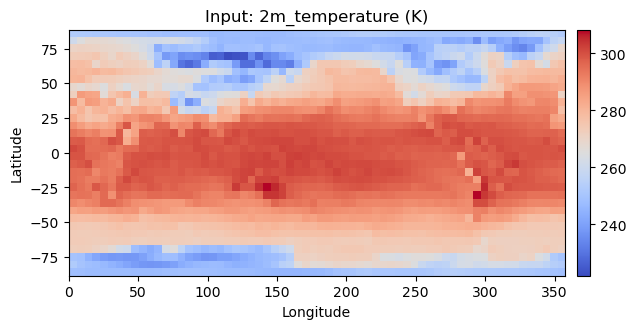

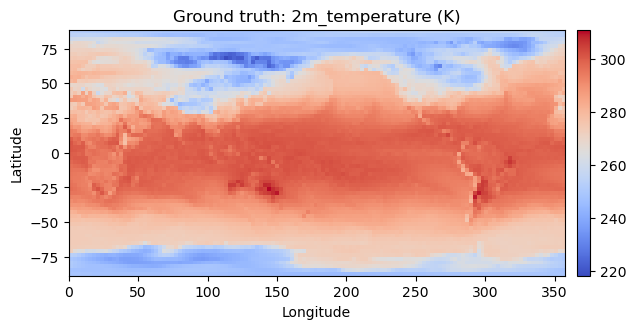

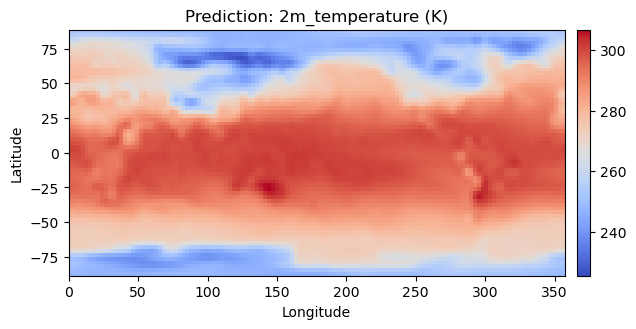

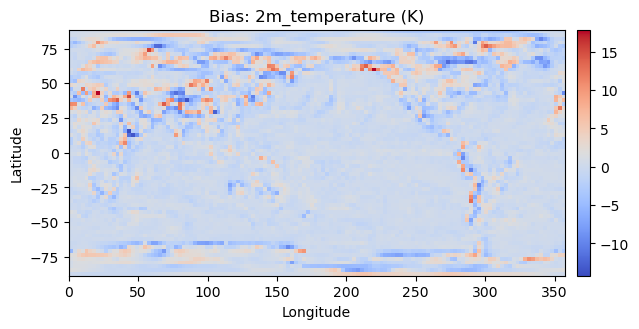

In [13]:
denorm = bilinear.test_target_transforms[0]
in_graphic = visualize_at_index(
    bilinear,
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)

Moreover, ClimateLearn can display the mean bias, which is the average bias at each coordinate across the entire testing set.

18it [00:03,  5.62it/s]


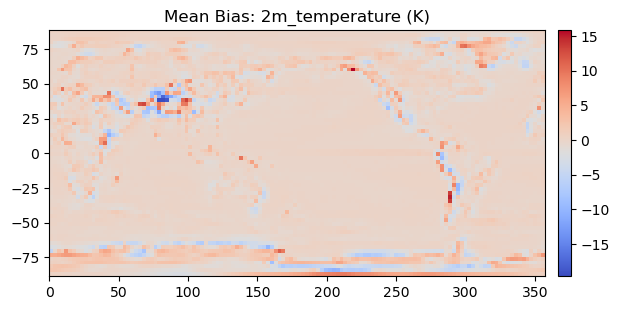

In [14]:
visualize_mean_bias(
    dm, bilinear, out_transform=denorm, variable="2m_temperature", src="era5"
)

Next, we can train a deep learning model to do weather forecasting. In the following code cell, we load the ResNet-based model architecture defined by [Rasp & Theurey, 2020](https://arxiv.org/abs/2008.08626).

In [4]:
vit = load_downscaling_module(data_module=dm, architecture="vit")

Loading architecture: vit
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: mse
No train transform
Loading validation loss: rmse
Loading validation loss: pearson
Loading validation loss: mean_bias
Loading validation loss: mse
Loading validation transform: denormalize
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: rmse
Loading test loss: pearson
Loading test loss: mean_bias
Loading test loss: mse
Loading test transform: denormalize
Loading test transform: denormalize
Loading test transform: denormalize
No test transform


To train the model, we leverage PyTorch Lightning for GPU acceleration, specification of floating-point precision (we use 16-bit here to speed up training), and callbacks such as early stopping, model checkpointing, and logging to TensorBoard. Recall from previous text cells why we use `lat_mse:aggregate` as the early stopping criterion. For sake of example, we train for just one epoch, but to obtain good results, one should train for much longer.

In [6]:
pl.seed_everything(0)
default_root_dir = (
    f"/app/data/ClimateLearn/experiments/downscaling-ERA5-ERA5/vit_downscaling_t2m_notebook"
)
logger = TensorBoardLogger(save_dir=f"{default_root_dir}/logs")
early_stopping = "val/mse:aggregate"
callbacks = [
    RichProgressBar(),
    RichModelSummary(max_depth=1),
    EarlyStopping(monitor=early_stopping, patience=5),
    ModelCheckpoint(
        dirpath=f"{default_root_dir}/checkpoints",
        monitor=early_stopping,
        filename="epoch_{epoch:03d}",
        auto_insert_metric_name=False,
    ),
]
trainer = pl.Trainer(
    enable_progress_bar=True,
    logger=logger,
    callbacks=callbacks,
    default_root_dir=default_root_dir,
    accelerator="gpu",
    devices=[2],
    max_epochs=1,
    # strategy="ddp",
    precision="16-mixed",
)

Seed set to 0
Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
train_dataloader = dm.train_dataloader()
i = 0
for _ in train_dataloader:
    i += 1

print(f"Number of batches in train dataloader: {i}")

Number of batches in train dataloader: 616


In [17]:
trainer.fit(vit, datamodule=dm)

You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


/opt/conda/envs/bias_correction/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /app/data/ClimateLearn/processed/downscaling-ERA5-ERA5/vit_downscaling_t2m_notebook/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


┏━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ net  │ Sequential │  1.1 M │
└───┴──────┴────────────┴────────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4

Output()

/opt/conda/envs/bias_correction/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py
:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of 
the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/opt/conda/envs/bias_correction/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py
:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of
the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=1` reached.


After fitting the model, we can test it using the best checkpoint saved during training.

In [27]:
test_dataloader = dm.test_dataloader()
i = 0
for _ in test_dataloader:
    i += 1

print(f"Number of batches in test dataloader: {i}")

Number of batches in test dataloader: 18


In [18]:
trainer.test(vit, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at /app/data/ClimateLearn/processed/downscaling-ERA5-ERA5/vit_downscaling_t2m_notebook/checkpoints/epoch_000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]
Loaded model weights from the checkpoint at /app/data/ClimateLearn/processed/downscaling-ERA5-ERA5/vit_downscaling_t2m_notebook/checkpoints/epoch_000.ckpt
/opt/conda/envs/bias_correction/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/mean_bias:2m_temperature │      0.5699912905693054       │
│   test/mean_bias:aggregate    │      0.5699912905693054       │
│    test/mse:2m_temperature    │       446.7449951171875       │
│      test/mse:aggregate       │       446.7449951171875       │
│  test/pearson:2m_temperature  │      -0.0595640130341053      │
│    test/pearson:aggregate     │      -0.0595640130341053      │
│   test/rmse:2m_temperature    │      21.099016189575195       │
│      test/rmse:aggregate      │      21.099016189575195       │
└───────────────────────────────┴───────────────────────────────┘

[{'test/rmse:2m_temperature': 21.099016189575195,
  'test/rmse:aggregate': 21.099016189575195,
  'test/pearson:2m_temperature': -0.0595640130341053,
  'test/pearson:aggregate': -0.0595640130341053,
  'test/mean_bias:2m_temperature': 0.5699912905693054,
  'test/mean_bias:aggregate': 0.5699912905693054,
  'test/mse:2m_temperature': 446.7449951171875,
  'test/mse:aggregate': 446.7449951171875}]

As before, let's visualize the bias of our deep learning model on the first sample of the testing set (the mean bias computation will take a while, even on GPU).

0it [00:00, ?it/s]


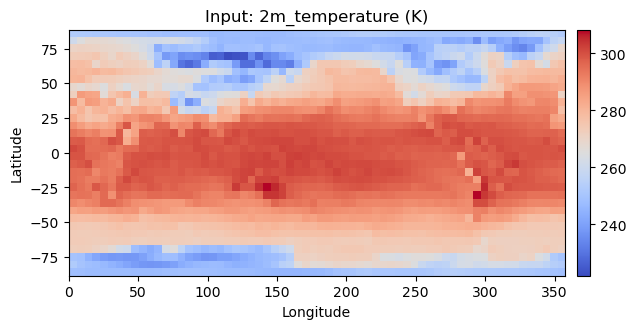

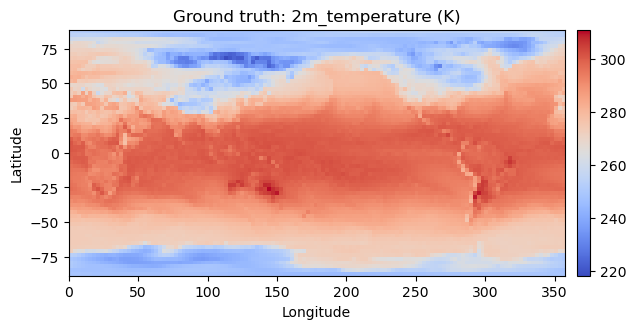

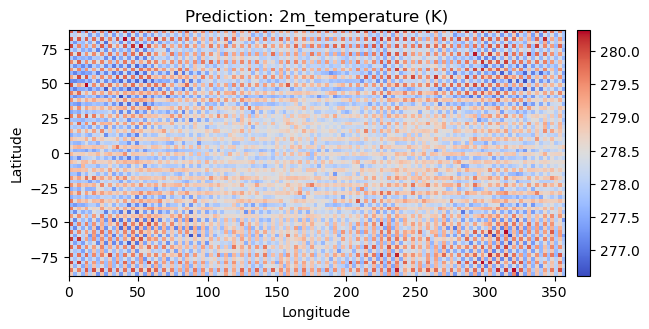

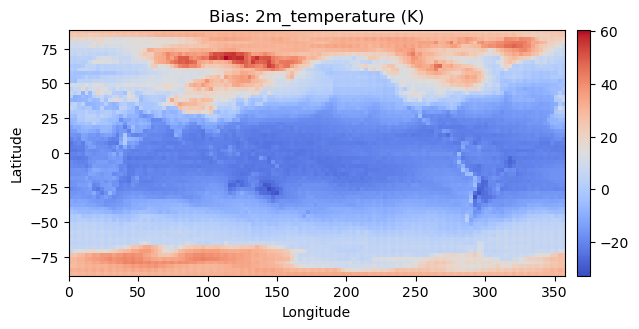

In [32]:
denorm = vit.test_target_transforms[0]
in_graphic = visualize_at_index(
    vit.to(device="cuda:1"),
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)

Congratulations on completing this quickstart of ClimateLearn. In this tutorial, we used ClimateLearn to download and process data from ERA5. Then, we evaluated two baseline methods, persistence and climatology, followed by visualizations of persistence's bias on one specific testing sample and its mean bias across all testing samples. Finally, we trained a deep learning model and visualized its bias on a specific testing sampkle.

Since ClimateLearn was designed to be plug-and-play, each step of this pipeline can be customized.

- Instead of using ERA5 data for forecasting, maybe you would like to use data from CMIP6. Specifically, ClimateLearn supports downloading and processing data from the [MPI-ESM1.2-HR](https://agupubs.onlinelibrary.wiley.com/doi/toc/10.1002/\(ISSN\)1942-2466.MPIESM1-2) model with the following function `cl.data.download_mpi_esm1_2_hr`.
- Or, instead of doing `direct-forecasting`, you could perform `continuous-forecasting` or `iterative-forecasting` by swapping out the first argument to the constructor of `cl.data.IterDataModule`.
- You could also change the deep learning model, optimizer, and learning rate scheduler by loading a different architecture or specifying your own bespoke solutions like:
```python
model = cl.load_forecasting_module(
    data_module=dm,
    model="resnet",
    model_kwargs={"n_blocks": 4, "history": 5},
    optim="adamw",
    optim_kwargs={"lr": 5e-4},
    sched="linear-warmup-cosine-annealing",
    sched_kwargs={"warmup_epochs": 5, "max_epochs": 50}
)
```

The source code for ClimateLearn is publicly available on GitHub at https://github.com/aditya-grover/climate-learn, and the documentation website is https://climatelearn.readthedocs.io/.